[딥러닝입문] 위키독스 기반으로 작성된 모델링
https://wikidocs.net/217687

# 0) 모듈 실행

##기본 모듈

In [5]:
# Matplotlib 와 pandas 그래프에서 한글 사용 설정
import sys

## 노트북이 코랩에서 실행중인지 체크
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/frontend select Noninterative' | debconf-set-selections
  ## 나눔 폰트 설치
  !sudo apt-get -qq -y install fonts-nanum
  import matplotlib.font_manager as fm
  font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
  for fpath in font_files:
    fm.fontManager.addfont(fpath)

  # 나눔바른고딕 폰트 설정
  import matplotlib.pyplot as plt
  plt.rc('font', family='NanumBarunGothic')
  # 마이너스 기호 표시 오류 수정
  import matplotlib
  matplotlib.rcParams['axes.unicode_minus'] = False


debconf: unable to initialize frontend: Noninterative
debconf: (Can't locate Debconf/FrontEnd/Noninterative.pm in @INC (you may need to install the Debconf::FrontEnd::Noninterative module) (@INC contains: /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.34.0 /usr/local/share/perl/5.34.0 /usr/lib/x86_64-linux-gnu/perl5/5.34 /usr/share/perl5 /usr/lib/x86_64-linux-gnu/perl-base /usr/lib/x86_64-linux-gnu/perl/5.34 /usr/share/perl/5.34 /usr/local/lib/site_perl) at (eval 17) line 2, <> line 1.)
debconf: falling back to frontend: Noninteractive
Selecting previously unselected package fonts-nanum.
(Reading database ... 121920 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 48.6 MB/s eta 0:00:00


In [8]:
import re
import urllib.request
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [9]:
from konlpy.tag import Okt

okt = Okt()

# 1) 데이터 가져오기

## 감성대화 말뭉치
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86
- 일반인 1,500명 대상의 인터뷰 및 크라우드 소싱 수행
- 우울증 환자 대상 WOZ 대화 수집

=> 전처리 과정으로 "한사람만의 대화를 줄글로 변형 - 질문 제거"

### 1. 데이터 가져오기

In [10]:
train = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Training_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Training.xlsx")
test = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Validation_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Validation.xlsx")

In [11]:
train_df = train.copy()
test_df = test.copy()

### 2. 전처리

In [12]:
# "사람문장3" 결측값 대체
train_df.fillna('',inplace=True)
test_df.fillna('',inplace=True)

# 문장 병합
train_df['사람문장'] = train_df['사람문장1']+train_df['사람문장2']+train_df['사람문장3']
test_df['사람문장'] = test_df['사람문장1']+test_df['사람문장2']+test_df['사람문장3']

# "감정 분류"과 "문장"만 추출
train_df = train_df[['사람문장', '감정_대분류']]
test_df = test_df[['사람문장', '감정_대분류']]

# 컬럼명 변경
train_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)
test_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)

# label encoding
le = LabelEncoder()
le=le.fit(train_df['sentiment'])
train_df['target']=le.transform(train_df['sentiment'])

le=le.fit(test_df['sentiment'])
test_df['target']=le.transform(test_df['sentiment'])

# text, target
train_conv = train_df[['text','target']]
test_conv = test_df[['text','target']]

<ipython-input-12-f384f47c5c78>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={'사람문장': 'text',
<ipython-input-12-f384f47c5c78>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns={'사람문장': 'text',
<ipython-input-12-f384f47c5c78>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['target']=le.transform(train_df['sentiment'])


In [13]:
# 라벨 인코딩 결과 확인
sentiment = train_df[['sentiment', 'target']].drop_duplicates(subset=['sentiment']) # sentiment 컬럼에 대해 중복된 값을 갖고 있는 열 제거
df_unique = sentiment.sort_values(by='target', ascending=True)
df_unique = df_unique.reset_index(drop=True)
df_unique

,sentiment,target
0,기쁨,0
1,당황,1
2,분노,2
3,불안,3
4,상처,4
5,슬픔,5


# 2) 데이터 증강
데이터 불균형으로 인해 분류 전에 전처리하는 방식인 smote 택함

**SMOTE(= Synthetic Minority Over-sampling Technique)**

SMOTE는 합성을 기반으로 하는 방법으로, minority class의 샘플을 가져와 이들을 잇는 선에서 중간값을 택하여 만들어내는 방식

Train

In [14]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = train_conv.text.to_numpy().reshape(-1, 1)
target = train_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
train_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
train_conv2

,text,target
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테...,2
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....,2
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,2
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,2
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.상사인 나에게 먼...,2
...,...,...
55915,우리 가족은 나를 사랑하지 않는 것 같아서 집을 나가고 싶어.오늘은 내 생일인데 가...,5
55916,자식들이 병문안을 왔는데 그저 내가 빨리 죽길 바라는 눈치였어.자식 낳아 봤자 소용...,5
55917,부모님이 자꾸 회사 일을 도우래. 나랑 너무 안 맞아서 하기 싫어.내 전공이랑 전혀...,5
55918,친구가 진정 친구가 맞을까? 그냥 필요할 때만 찾는 사람인 거 같아.이런 관계가 맞...,5


Test

In [15]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = test_conv.text.to_numpy().reshape(-1, 1)
target = test_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
test_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
test_conv2

,text,target
0,이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너...,3
1,회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워.나에게 너무 크게...,3
2,상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워.무섭게 생겼는데도 업무를 보려면...,3
3,이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다.첫 직장이...,3
4,직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼.내가 낯가림이 심해서 친해질 수 ...,3
...,...,...
7537,내 친한 친구는 항상 반에서 따돌림을 받아. 그런데도 항상 웃는데 그걸 보고 있으면...,5
7538,아무도 내 이야기를 귀 기울여 들어주지 않아. 답답하고 속상해.정말 아무도 내 이야...,5
7539,남자친구의 핸드폰을 우연히 들여다보게 되었는데 나에 대한 험담들이 쓰여있었어. 겉으...,5
7540,취업에 성공한 사람들 때문에 자괴감을 느끼게 돼.취업 성공 수기를 읽어 보면 다들 ...,5


# 3) 데이터 전처리
모델 적합을 위해 데이터가 적절히 전처리되어야 하며 이때 전처리는 토큰화, 정수 인코딩, 패딩을 의미함

- 불용어 적용 및 토큰화
- 데이터 분할
- 단어 집합 생성
- 정수 인코딩
- 패딩

In [20]:
dataset_train = train_conv2.copy()
dataset_test = test_conv2.copy()

In [21]:
y_train = np.array(dataset_train['target'])
y_test = np.array(dataset_test['target'])

불용어 적용 및 토큰화

In [22]:
# 한국어 불용어 사전 적용 https://bab2min.tistory.com/544
'''with open('/content/한국어불용어100.txt') as f:
    lines = f.readlines()
stopwords = []
for stopword in lines:
    stopwords.append(stopword.split('\t')[0])
print(stopwords)
'''
stopwords = ['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람',
              '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일',
              '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또',
              '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키',
              '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신',
              '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이',
              '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도',
              '좀', '원', '잘', '통하', '소리', '놓']


In [23]:
X_train = []
for sentence in tqdm(dataset_train['text']):
    tokenized_sentence = okt.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 55920/55920 [06:58<00:00, 133.58it/s]


In [24]:
X_test = []
for sentence in tqdm(dataset_test['text']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 7542/7542 [00:52<00:00, 143.69it/s]


데이터 분할

In [26]:
# 학습하는 동안의 성능 평가를 진행할 검증 데이터가 추가로 필요
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size=0.2, random_state=0,
                                                      stratify=y_train)

단어 집합 생성

In [81]:
# 단어 수
word_list = []
for sent in X_train:
    for word in sent:
      word_list.append(word)

word_counts = Counter(word_list) # 총 단어 수 39924

# 등장 빈도수 순서로 단어 저장
vocab = sorted(word_counts, key=word_counts.get, reverse=True)

In [82]:
threshold = 3
total_cnt = len(word_counts) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 39924
등장 빈도가 2번 이하인 희귀 단어의 수: 23414
단어 집합에서 희귀 단어의 비율: 58.64642821360585
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.400420257940687


In [83]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
vocab_size = total_cnt - rare_cnt
vocab = vocab[:vocab_size] # 단어 집합의 크기는 18724

word_to_index = {}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1

for index, word in enumerate(vocab) :
  word_to_index[word] = index + 2

vocab_size = len(word_to_index)

정수 인코딩

In [84]:
def texts_to_sequences(tokenized_X_data, word_to_index):
  encoded_X_data = []
  for sent in tokenized_X_data:
    index_sequences = []
    for word in sent:
      try:
          index_sequences.append(word_to_index[word])
      except KeyError:
          index_sequences.append(word_to_index['<UNK>'])
    encoded_X_data.append(index_sequences)
  return encoded_X_data

In [85]:
encoded_X_train = texts_to_sequences(X_train, word_to_index)
encoded_X_valid = texts_to_sequences(X_valid, word_to_index)
encoded_X_test = texts_to_sequences(X_test, word_to_index)

In [86]:
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

패딩

텍스트의 최대 길이 : 105
텍스트의 평균 길이 : 34.095311277523194


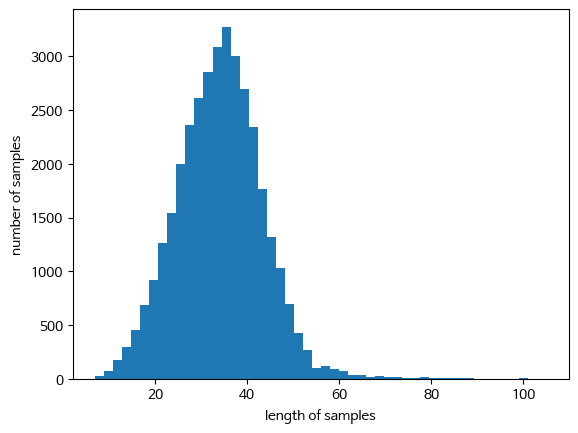

In [87]:
print('텍스트의 최대 길이 :',max(len(text) for text in encoded_X_train))
print('텍스트의 평균 길이 :',sum(map(len, encoded_X_train))/len(encoded_X_train))
plt.hist([len(text) for text in encoded_X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [88]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [107]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 96.42617637196825


In [108]:
def pad_sequences(sentences, max_len):
  features = np.zeros((len(sentences), max_len), dtype=int)
  for index, sentence in enumerate(sentences):
    if len(sentence) != 0:
      features[index, :len(sentence)] = np.array(sentence)[:max_len]
  return features

padded_X_train = pad_sequences(encoded_X_train, max_len=max_len)
padded_X_valid = pad_sequences(encoded_X_valid, max_len=max_len)
padded_X_test = pad_sequences(encoded_X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (35788, 50)
검증 데이터의 크기 : (8948, 50)
테스트 데이터의 크기 : (7542, 50)


In [109]:
print('첫번째 샘플의 길이 :', len(padded_X_train[0]))
print('첫번째 샘플 :', padded_X_train[0])

첫번째 샘플의 길이 : 50
첫번째 샘플 : [ 516 1095   30  516  109   31  516  104 3238   58   66    2  290  410
   60  313    6  443   58 1252    2  115   23 1384  109   11 1669  151
   11   43    2    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


# 4) LSTM 적합
https://wikidocs.net/217687

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [111]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("cpu와 cuda 중 다음 기기로 학습함:", device)

cpu와 cuda 중 다음 기기로 학습함: cuda


In [112]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))

In [113]:
# 텍스트 분류를 위해 LSTM 기반 모델 정의
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        # LSTM은 (hidden state, cell state)의 튜플을 반환합니다
        lstm_out, (hidden, cell) = self.lstm(embedded)  # lstm_out: (batch_size, seq_length, hidden_dim), hidden: (1, batch_size, hidden_dim)

        last_hidden = hidden.squeeze(0)  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

In [114]:
# train
encoded_train = torch.tensor(padded_X_train).to(torch.int64) # 정수형 데이터 변환
train_dataset = torch.utils.data.TensorDataset(encoded_train, train_label_tensor)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32) # 데이터셋 미니배치로 나눠 랜덤하게 섞음

# test
encoded_test = torch.tensor(padded_X_test).to(torch.int64)
test_dataset = torch.utils.data.TensorDataset(encoded_test, test_label_tensor)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=1)

# valid
encoded_valid = torch.tensor(padded_X_valid).to(torch.int64)
valid_dataset = torch.utils.data.TensorDataset(encoded_valid, valid_label_tensor)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, batch_size=1)

In [115]:
total_batch = len(train_dataloader)
print('총 배치의 수 : {}'.format(total_batch)) # 배치 크기가 32일 경우 데이터 묶음 1119개 생성

총 배치의 수 : 1119


In [116]:
# 하이퍼파라미터 지정
embedding_dim = 100
hidden_dim = 128
output_dim = 6
learning_rate = 0.01
num_epochs = 10

model = TextClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
model.to(device)

TextClassifier(
  (embedding): Embedding(16512, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

평가 코드 작성

In [118]:
def calculate_accuracy(logits, labels):
    # _, predicted = torch.max(logits, 1)
    predicted = torch.argmax(logits, dim=1)
    correct = (predicted == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [119]:
def evaluate(model, valid_dataloader, criterion, device):
    val_loss = 0
    val_correct = 0
    val_total = 0

    model.eval() # 모델을 평가 모드로 설정
    with torch.no_grad(): # 자동 미분 엔진에서 그래디언트 계산 비활성화하여 기울기 계산할 필요 없음
        # 데이터로더로부터 배치 크기만큼의 데이터를 연속으로 로드
        for batch_X, batch_y in valid_dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 모델의 예측값
            logits = model(batch_X)

            # 손실을 계산
            loss = criterion(logits, batch_y)

            # 정확도와 손실을 계산함
            val_loss += loss.item()
            val_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
            val_total += batch_y.size(0)

    val_accuracy = val_correct / val_total
    val_loss /= len(valid_dataloader)

    return val_loss, val_accuracy


학습

In [120]:
num_epochs = 5

# Training loop
best_val_loss = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Training
    train_loss = 0
    train_correct = 0
    train_total = 0
    model.train()
    for batch_X, batch_y in train_dataloader:
        # Forward pass
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        # batch_X.shape == (batch_size, max_len)
        logits = model(batch_X)

        # Compute loss
        loss = criterion(logits, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate training accuracy and loss
        train_loss += loss.item()
        train_correct += calculate_accuracy(logits, batch_y) * batch_y.size(0)
        train_total += batch_y.size(0)

    train_accuracy = train_correct / train_total
    train_loss /= len(train_dataloader)

    # Validation
    val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 검증 손실이 최소일 때 체크포인트 저장
    if val_loss < best_val_loss:
        print(f'Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}. 체크포인트를 저장합니다.')
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')


Epoch 1/5:
Train Loss: 1.7761, Train Accuracy: 0.1884
Validation Loss: 1.6877, Validation Accuracy: 0.2690
Validation loss improved from inf to 1.6877. 체크포인트를 저장합니다.
Epoch 2/5:
Train Loss: 1.5381, Train Accuracy: 0.3159
Validation Loss: 1.4725, Validation Accuracy: 0.3496
Validation loss improved from 1.6877 to 1.4725. 체크포인트를 저장합니다.
Epoch 3/5:
Train Loss: 1.3163, Train Accuracy: 0.4530
Validation Loss: 1.2293, Validation Accuracy: 0.5470
Validation loss improved from 1.4725 to 1.2293. 체크포인트를 저장합니다.
Epoch 4/5:
Train Loss: 1.0395, Train Accuracy: 0.6177
Validation Loss: 1.0951, Validation Accuracy: 0.6054
Validation loss improved from 1.2293 to 1.0951. 체크포인트를 저장합니다.
Epoch 5/5:
Train Loss: 0.8850, Train Accuracy: 0.6815
Validation Loss: 1.1080, Validation Accuracy: 0.6047


모델 로드 및 평가

In [121]:
# 모델 로드
model.load_state_dict(torch.load('best_model_checkpoint.pth'))

# 모델을 device에 올립니다.
model.to(device)

TextClassifier(
  (embedding): Embedding(16512, 100)
  (lstm): LSTM(100, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [122]:
# 검증 데이터에 대한 정확도와 손실 계산
val_loss, val_accuracy = evaluate(model, valid_dataloader, criterion, device)

print(f'Best model validation loss: {val_loss:.4f}')
print(f'Best model validation accuracy: {val_accuracy:.4f}')


Best model validation loss: 1.0951
Best model validation accuracy: 0.6054


Best model validation loss: 1.0727
Best model validation accuracy: 0.6093

In [123]:
# 테스트 데이터에 대한 정확도와 손실 계산
test_loss, test_accuracy = evaluate(model, test_dataloader, criterion, device)

print(f'Best model test loss: {test_loss:.4f}')
print(f'Best model test accuracy: {test_accuracy:.4f}')

Best model test loss: 1.3176
Best model test accuracy: 0.5126


모델 테스트

In [124]:
index_to_tag = {0 : '기쁨', 1 : '당황', 2 : '분노', 3 : '불안', 4 : '상처', 5 : '슬픔'}

def predict(text, model, word_to_index, index_to_tag):
    # Set the model to evaluation mode
    model.eval()

    # Tokenize the input text
    tokens = okt.morphs(text) # 토큰화
    tokens = [word for word in tokens if not word in stopwords] # 불용어 제거
    token_indices = [word_to_index.get(token, 1) for token in tokens]

    # Convert tokens to tensor
    input_tensor = torch.tensor([token_indices], dtype=torch.long).to(device)  # (1, seq_length)

    # Pass the input tensor through the model
    with torch.no_grad():
        logits = model(input_tensor)  # (1, output_dim)

    # Get the predicted class index
    predicted_index = torch.argmax(logits, dim=1)

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index.item()]

    return predicted_tag


In [126]:
test_input = "오늘은 콩콩이가 내 배를 너무 차서 장을 보다가 집으로 돌아왔다. \
                지난주보다 활발히 움직여서 빨리 콩콩이를 보고 싶다.\
                만날 날이 너무 기다려진다. 설렘으로 가득하다."
predict(test_input, model, word_to_index, index_to_tag)

'불안'

In [127]:
# 모두의 말뭉치
test_input = '#1 요즘 은근히 티비나 유튜브 보고 느끼는 점이 많은데(이 여성은 하루종일 폰만 봅니다) 1.언젠가 자신에 행동에 대한 결과는 나타난다는 점 \2.그리고 내눈에 변변치않아 보이는 사람이라도 배울점이 많을 수 있다는 것 아니 오히려 우연히 성공을 거둔 일프로의 자만섞인 조언을 얻는 것보다는 지금 내게 더 가까운 실패한 사람, 하지만 충분히 성공할만한 자질이 있었던 unlucky people의 체념한 말이 더 낫다고 느낀다. 그 이유는 내가 가진 열등감때문이기도 하고 사실 사람들은 본인을 잘 몰라서 괜한 곳에서 성공요인을 찾고 그것을 대단한 양 알려주니깐 그게 별 도움이 안된다. 근데 실패한 사람은 성공했을 뻔한 그 기억을 이모저모 살펴보니깐 꼭 어떤 일의 성공에 대한 것이 아니라도 인생전체에 대해 뼈깊게 잘 알려준다. "네 뜻대로 아무것도 이뤄지지 않는다는 것을 알아. 하지만 걱정하지마 모든 것은 완벽하게 이루어질 수 밖에 없어" 라는 양준일의 말이 내게 와닿는 이유는 몸부림을 쳐도 성공하기 힘들 것 같다는 생각에 무조건적인 부정이 아닌 그래도,최악의 상황이 와닥쳐도 그 상황에 가기까지의 나에게 수고했다고 인정해주는 것 같으니깐! 얼마전에 내 옛날 지식인 질문함(?)을 연어질하다가 집안상황도 지금보다 더 힘들고 마음적으로도 힘든 일이 많구 안그래도 사춘기여서 여러모로 지쳤을 중3 시절에 ‘행복하지않다.어떻게 행복해지나요?어떻게 지루하지않게 살 수 있나요?’라고 물었던 걸 발견했다. 그에 대한 답변이 정말 정성스럽고 공감가는 조언을 적어주셔서 거의 7년이 지난 지금에라도 채택했다. 지금봐도 와닿더라. 바뀌지않는 환경을 탓한다해서 너의 인생이 갑자기 지루함이 사라지는 게 아니다. 너희 어머님도 이런 너를 키우는 게 행복하기만 하겠니. 이렇게 놓아 버리고 있다가 나중에 후회할게 아니라 플랜비를 세워야한다. 좋지못한 학벌에서도 얼마든지 성공할 수 있다는 예외적인거지 전부 그런게 아니다 등등 잔소리처럼 느껴질 수도 있는 말이지만 지금 들으니 왠지 공감이 가고 지금의 내가 그때의 내게 시공간의 벽을 넘어 말해줄 수 있다면 전해줄 수 있다면 딱 하고 싶은 말이 써있었다. 왜인지 감동이고 떨려서 추가질문으로 한마디도 던졌다.(어쩌면 들리지않는 메아리겠지만..!그래도.) 내가 대단한 시인이거나 소설작가로 살고 있는 것도 아니고 사건사고가 빵빵터지는 스펙타클한 삶도 아니지만 내게도 소소하게나마 이런 문학적이고 로맨틱한 일이 있을 수 있네 라는 생각이 들었다. 영화로 생각해보자면 "시월애"가 생각나더라. #2 고딩때가 그리워요! 근데 친구들은 그때보다 더 잘살면 잘 살았지 못살거나 그리워 하지는 않네요...^^ㅠㅠ 오늘은 시험이 2개나 있는 날입니다. 할일이 3개 있구/ 1.슬로건 준등기 2.대충 시험공부 3.에이티즈 콘서트입금 / 고로치만 공부는 절대 안하고 일기 갈기도록 함. 고민없는 요즘 인생 중에 대사가 있다면 "뭐해먹고 사노? 이런 인간쓰레기도 고용하시나요?"정도다. 이제 곧 모든 서포터즈 활동이 끝나서(한달마다 꼬박 입금되던 여윳돈 20이 사라진다) 또 다른 걸 알아봐야하는데....뭐하는지;; 뭘할지 고민하는 선 뭐 문제가 안되긴 한다(너무 나대야하는 것빼고 다 지원할꺼에요.) 제발 뽑아주세요ㅠ.ㅠ 대충 장학금도 더 알아보고 대충 자소서 갈기고 대충 토익 만들고 토스 만들고 이 모든 걸 방학내에 해결해야 한다! 남들은 다 발전할 때 얻는 게 너도 있어보면 어떨까.. 발전까지는 안바래'

predict(test_input, model, word_to_index, index_to_tag)

'기쁨'

In [130]:
# 모두의 말뭉치
test_input = '어제 12월 31일, 나는 가요대제전 사전 녹화를 방청하고 왔다. 사전 녹화는 일산 MBC 스튜디오에서 진행하기 때문에 일산과 거리가 먼 강북구에 살고, 운전면허도 없는 나는 출석 체크 시간을 맞추기 위해서 새벽 4시에 기상을 한 후 버스와 지하철을 타야 했다. 이번 겨울이 지구온난화 영향 때문인지 유독 따뜻했지만 어제는 웬일인지 너무도 추웠다. 덕분에 나는 일산의 칼바람과 함께 입장을 기다려야 했고 오전 10시가 거의 다 되어서야 스튜디오 안으로 입장을 했다. 내가 이렇게 고생을 해서 녹화에 참여한 이유는 좋아하는 아이돌 그룹인 엔시티 드림을 보기 위해서였다. 스튜디오에 들어가니 멤버들은 이미 도착하여 준비 운동도 하고, 스태프들과 의견도 나누고 있었다. 함께 녹화를 진행하는 스트레이 키즈라는 그룹도 마찬가지였다. 사실 최근 일주일 동안 다른 스케줄들로 멤버들을 벌써 네 번째 보는 것이었지만 어제의 멤버들은 또 어제만의 매력이 있었다. 녹화는 생각보다 꽤 길게 진행되었고, 중간에 모니터링 시간과 메이크업 수정 시간이 생길 때마다 멤버들은 다정하게 우리(팬들)에게 대화를 걸었다. 멤버들은 우리가 본인들을 보려고 새벽부터 일어났다는 것에 진심으로 놀라워했다. 하지만 분명히 우리보다 멤버들이 헤어와 메이크업 준비 때문에 더 일찍 일어났을 것이다. 한 멤버가 날씨가 춥고 감기에 걸리기 쉬우니 독감 주사를 꼭 맞고, 밥과 비타민을 꼭 챙겨 먹으라고 말을 했을 때는 웃음이 나왔다. 그들은 우리 엄마보다 잔소리가 심하다. 또 멤버들은 간간이 서로에게 장난도 치고, 스트레이 키즈의 멤버들과는 어색하게 인사도 나누었다. 녹화 마지막에는 방송인 장성규가 나와 그들과 함께 방탄소년단의 작은 것들을 위한 시의 춤을 춰 폭소를 안겨주었다. 그렇게 엔시티 드림의 사전 녹화가 끝나고 마지막까지 그들의 걱정 어린 잔소리를 들은 후 집으로 오는 길에는 많이 피곤했었는지 버스 안에서 기절하다시피 잠이 들었다. 그리고 이것을 쓰고 있는 지금 오랜 시간 서있던 것의 후폭풍인지 발목부터 골반까지 온통 쑤시고 저려 도저히 침대에서 일어날 수가 없다.'

predict(test_input, model, word_to_index, index_to_tag)

'불안'

In [131]:
# 모두의 말뭉치
test_input = '9월 20일- 오늘은 아침에 늦게 일어났다.딸들이 시켜줘서 눈썹 수정술을 받았는데 너무 찐하게 되어서 나가지도 못하고 해서 늦게 일어난거다. <name1>이가 7시 35분에 와 둘이 같이 밥을 해서 먹고, <name2>이는 너무 찐하다고 놀라기도 했다. 껍질이 몇일 잇으면 벗겨진다고 했는데 처음이라 그런거라고 했다. 다행이다. 런닝머신하고 일기쓴다.'
predict(test_input, model, word_to_index, index_to_tag)

'기쁨'